In [5]:

import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import primitive_interior
import trimesh



In [38]:
# Parameters:
# center (x,y,z), axis (a_x, a_y, a_z), radius
# surface parameterization: u,v

# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v
def cylinder(parameters):
    center = parameters[:3]
    axis = parameters[3:6]
    radius = parameters[6]
    length = parameters[7]
    z_dir = axis / torch.linalg.norm(axis)

    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]), dim=-1)
    x_dir = torch.cross(y_dir, z_dir, dim=-1)

    # Calculate rotation angles
    angle_x = torch.atan2(x_dir[1], x_dir[0])
    angle_y = torch.atan2(y_dir[2], torch.sqrt(y_dir[0]**2 + y_dir[1]**2))
    angle_z = torch.atan2(z_dir[1], z_dir[0])

    # Calculate translation
    translation = center[:3]

    random_coords = torch.rand(1000, 3)

    u = random_coords[:,0:1]
    v = random_coords[:,1:2]

    v = v * length - length / 2

    return center + radius * x_dir * torch.cos(2*torch.pi*u) + radius * y_dir * torch.sin(2*torch.pi*u) + axis * v, translation, torch.tensor([angle_x, angle_y, angle_z])

# It returns a 3-valued tuple, the first element is the regular parameters, the two following ones are translation and rotation.  

In [43]:

init_parameters = torch.tensor([3.,5,0,10,3,2,10, 10])
cyl = cylinder(init_parameters)
points_cyl = cyl[0].numpy()
translation = cyl[1]
rotation = cyl[2]
print(translation, rotation)
mp.plot(points_cyl, shading={'point_size':2})



'''
init_parameters = torch.tensor([0.,0,0,0,0,6,10, 3])
points_cyl = torus(init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''
'''
init_parameters = torch.tensor([0.,0,0,0,0,6,50, 30, 20])
points_cyl = rectangle(parameters=init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''
'''
init_parameters = torch.tensor([0.,0,0,0,0,6,30])
points_cyl = hemisphere(parameters=init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''

tensor([3., 5., 0.]) tensor([-1.1619, -0.9828,  0.2915])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.5506191…

"\ninit_parameters = torch.tensor([0.,0,0,0,0,6,30])\npoints_cyl = hemisphere(parameters=init_parameters).numpy()\nmp.plot(points_cyl, shading={'point_size':2})\n"

In [10]:
# Loading a mesh and do uniformly samplings on the surface

# mesh = trimesh.load_mesh('slack_files/clip_20_15_1_15_10.obj')
# mesh = trimesh.load_mesh('cloth_hanger.obj')
mesh = trimesh.load_mesh('step2/reduced_mesh/segmentedRod.obj')

# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)  # sample normally? 
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)


mp.plot(points_numpy, shading={'point_size': 5})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.6134185…

  0%|          | 0/3000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

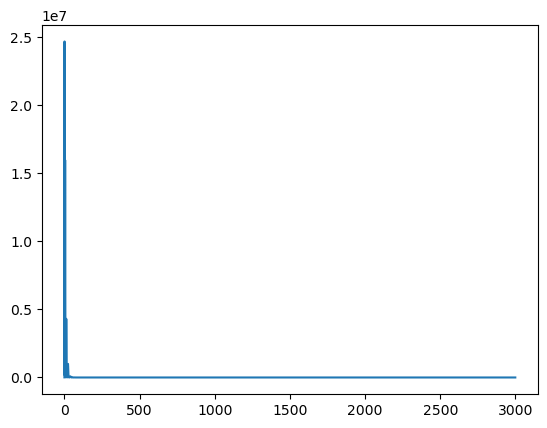

In [34]:
# diff. learning on a certain mesh input

import pytorch3d 
from pytorch3d.loss import chamfer_distance

# opt_parameters_init_stage = torch.tensor([0.,0,0, 1,1,1,1]) # an initial parameter close to the given param
# normal distribution
opt_params = torch.randn(8) # <==== ALSO change this line
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 100) # 100 is a good lr
losses = []

points_tensor = points_tensor.view(1, -1, 3) 

for _ in tqdm(range(3000)): # for the progress bar
    optimizer.zero_grad()
    opt_points = cylinder(opt_params) # <==== THIS line is what should be changed for different primitive
    opt_points = opt_points.view(1, -1, 3)

    # loss = ((points - opt_points)**2).sum() # TODO: change to champfer loss | volume matrix sampling | closed meshes?
    loss = chamfer_distance(x = points_tensor, y = opt_points) # returns a 2-element tuple? I suppose the first element is what we want
    loss = loss[0]
    
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())
plt.plot(losses)
plt.show

In [35]:
points_tensor = points_tensor.reshape(-1, 1, 3)
# plot = mp.plot(points.numpy(), return_plot=True, shading={'point_size':.5})
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':5})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':5, 'point_color':'green'})
print(opt_points.shape)
print(opt_params)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.6134185…

torch.Size([1000, 1, 3])
tensor([ 4.4989e+00, -2.5474e+01,  7.3235e+00, -5.2890e+01, -5.2547e-01,
        -2.7464e-01, -3.0950e+02, -5.7150e+00], requires_grad=True)


In [36]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

def parameter(opt_points):
    # Assuming opt_points is a [N, 3] tensor
    opt_points_np = opt_points.detach().cpu().numpy().reshape(-1, 3)

    pca = PCA(n_components=3)
    pca.fit(opt_points_np)
    directions = pca.components_ 
    # print(directions)

    # find x-axis (assuming the longest component is x)
    x_axis_index = np.argmax(np.abs(directions[:, 0]))
    x_direction = directions[x_axis_index]  # x_axis_index is 0

    # calculate the center
    center = np.mean(opt_points_np, axis=0)

    # Project points onto the x_direction to find length and find the cylinder length
    projection_lengths = np.dot(opt_points_np - center, x_direction)
    min_proj, max_proj = np.min(projection_lengths), np.max(projection_lengths)
    cylinder_length = max_proj - min_proj

    # compute radius by considering the distance of points from the cylinder axis
    # project points onto the orthogonal plane
    orthogonal_projection = np.cross(opt_points_np - center, x_direction)
    radius = np.mean(np.linalg.norm(orthogonal_projection, axis=1))  # Mean radius
    return torch.tensor([center[0], center[1], center[2], 1, 0, 0, radius, cylinder_length], dtype=torch.float32)

# This opt_points is founder due to optimizing the cloud points above
# Which one should we use? What is the point of using ML to optimize the point cloud?
parameters = parameter(torch.clone(opt_points))
parameters2 = parameter(torch.clone(points_tensor))
print(parameters)
print(parameters2)


tensor([  6.3240, -25.4864,   7.5974,   1.0000,   0.0000,   0.0000,   3.4427,
        302.6579])
tensor([  4.4950, -25.4525,   7.5549,   1.0000,   0.0000,   0.0000,   3.7431,
        302.1064])


In [37]:
print(parameters)
print(parameters2)

points = cylinder(parameters).numpy()
points2 = cylinder(parameters2).numpy()


# mp.plot(points, shading={'point_size':5})

plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':5})

# points_tensor: original points 
# opt_points: the optimal cylinder learned from ML
# points: the cylinder from the parameters learned from Mingsheng's model applied on opt_points
# points2: the cylinder from the parameters learned from Mingsheng's model applied on points_tensor


# opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(points, shading={'point_size':5, 'point_color':'green'}) # Mingshegn(my(input))
plot.add_points(points2, shading={'point_size':5, 'point_color':'blue'}) # Mingsheng(input)


tensor([  6.3240, -25.4864,   7.5974,   1.0000,   0.0000,   0.0000,   3.4427,
        302.6579])
tensor([  4.4950, -25.4525,   7.5549,   1.0000,   0.0000,   0.0000,   3.7431,
        302.1064])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.6134185…

2